This Notebook contains an example of using the given VaLLA implementation over 1D regression datasets.

In [29]:
# Notebook reload options
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:

# Global Imports
import numpy as np
import torch
import pandas as pd
from torch.utils.data import DataLoader
import sys
from time import process_time as timer
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.cluster.vq import kmeans2

# Local Imports
sys.path.append("..")
from utils.pytorch_learning import fit_map, fit, forward
from src.valla import VaLLARegression
from src.ella import ELLA_Regression
from utils.models import get_mlp, create_ad_hoc_mlp
from laplace import Laplace

from utils.dataset import get_dataset

Theese are the parameters that determine the experiments. Most of these values are set to their default value. Please refer to `utils/process_flass.py` to know more about each parameter.

In [31]:
params = {
        "num_inducing": 5,
        "bnn_structure": [50, 50],
        "MAP_lr": 0.001,
        "MAP_iterations": 2000,
        "lr": 0.001,
        "iterations": 2000,
        "activation": torch.nn.Tanh,
        "device": "cpu",
        "dtype": torch.float64,
        "seed": 2147483647,
        "bb_alpha": 1,
        "prior_std": 1,
        "ll_std": 1
}

Set seed for reproductibility.

In [32]:
torch.manual_seed(params["seed"]);

Load Dataset and desired split.

In [33]:
dataset = get_dataset("synthetic")
train_dataset, train_test_dataset, test_dataset = dataset.get_split()

Number of samples:  76
Input dimension:  1
Label dimension:  1
Labels mean value:  [[-0.00642895]]
Labels standard deviation:  [[0.55109777]]


Create Data loaders for training and test partitions.

In [34]:
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
train_test_loader = DataLoader(train_test_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [35]:


f = get_mlp(
    train_dataset.inputs.shape[1],
    train_dataset.targets.shape[1],
    params["bnn_structure"],
    params["activation"],
    device=params["device"],
    dtype=params["dtype"],
)

# Define optimizer and compile model
opt = torch.optim.Adam(f.parameters(), lr=params["MAP_lr"])
criterion = torch.nn.MSELoss()

# Set the number of training samples to generate
# Train the model
start = timer()

loss = fit_map(
    f,
    train_loader,
    opt,
    criterion=torch.nn.MSELoss(),
    use_tqdm=True,
    return_loss=True,
    iterations=params["MAP_iterations"],
    device=params["device"],
)
end = timer()

Training :   5%|▍         | 99/2000 [00:00<00:01, 983.48 iteration/s]

Training : 100%|██████████| 2000/2000 [00:01<00:00, 1193.29 iteration/s]


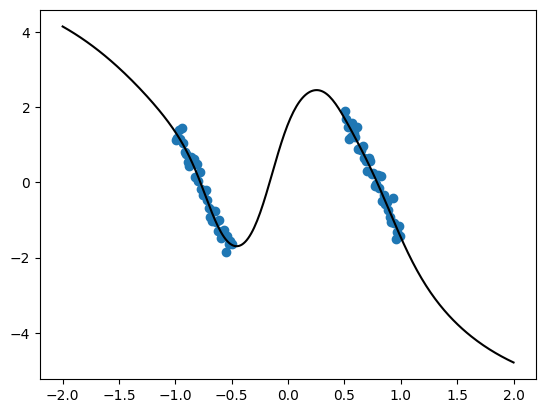

In [36]:

plt.scatter(train_dataset.inputs, 
                train_dataset.targets, 
                label="Training points")



sort = np.argsort(test_dataset.inputs.flatten())


plt.plot(
    test_dataset.inputs.flatten()[sort],
    f(torch.tensor(test_dataset.inputs)).detach().numpy().flatten()[sort],
    label="Predictions",
    color="black",
)
plt.show()

# LLA

In [37]:
# 'all', 'subnetwork' and 'last_layer'
subset = "all"
# 'full', 'kron', 'lowrank' and 'diag'
hessian = "kron"
X = test_dataset.inputs
la = Laplace(f, "regression", subset_of_weights=subset, hessian_structure=hessian)
la.fit(train_loader)

log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(
    1, requires_grad=True
)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-3)
for i in tqdm(range(params["iterations"])):
    hyper_optimizer.zero_grad()
    neg_marglik = -la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

prior_std = np.sqrt(1 / np.exp(log_prior.detach().numpy())).item()
log_variance = 2*log_sigma.detach().numpy().item()




100%|██████████| 2000/2000 [00:01<00:00, 1715.36it/s]


In [38]:
print("Optimal GP prior std: ", prior_std)
print("Optimal GP likelihoog log variance: ", log_variance)


Optimal GP prior std:  1.1758743524551392
Optimal GP likelihoog log variance:  -1.8718857765197754


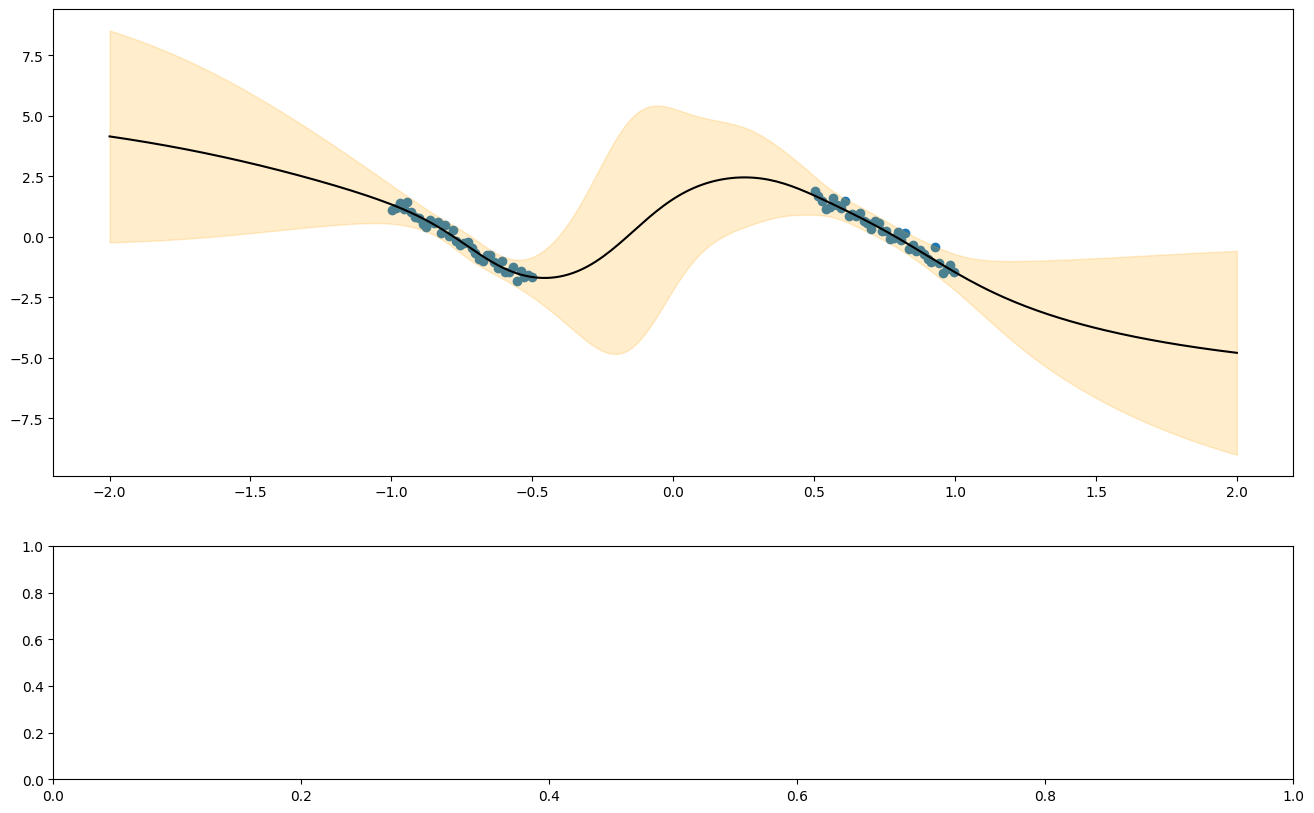

In [50]:
plt.rcParams["pdf.fonttype"] = 42
fig, axis = plt.subplots(2, 1, 
                         gridspec_kw={"height_ratios": [2, 1]}, 
                         figsize=(16, 10))


axis[0].scatter(train_dataset.inputs, 
                train_dataset.targets, 
                label="Training points")


lla_mean, lla_var = la._glm_predictive_distribution(
    torch.tensor(test_dataset.inputs))
lla_std = np.sqrt(lla_var).flatten()


sort = np.argsort(test_dataset.inputs.flatten())


axis[0].plot(
    test_dataset.inputs.flatten()[sort],
    lla_mean.flatten()[sort],
    label="Predictions",
    color="black",
)
axis[0].fill_between(
    test_dataset.inputs.flatten()[sort],
    lla_mean.flatten()[sort] - 2 * lla_std[sort],
    lla_mean.flatten()[sort] + 2 * lla_std[sort],
    alpha=0.2,
    label="VaLLA uncertainty",
    color="orange",
)
ylims = axis[0].get_ylim()
plt.show()

# ELLA

In [40]:
ella = ELLA_Regression(
    create_ad_hoc_mlp(f),
    f.output_size,
    params["num_inducing"],
    np.min([params["num_inducing"], 20]),
    prior_std=prior_std,
    log_variance = log_variance,
    seed=params["seed"],
    y_mean=train_dataset.targets_mean,
    y_std=train_dataset.targets_std,
    device=params["device"],
    dtype=params["dtype"],
)

In [41]:
ella.fit_loader(
            torch.tensor(train_dataset.inputs, 
                         device=params["device"], 
                         dtype=params["dtype"]),
            torch.tensor(train_dataset.targets,
                         device=params["device"], 
                         dtype=params["dtype"]),
            train_loader,
            verbose = True,
        )

Training : 100%|██████████| 1/1 [00:00<00:00, 226.65iteration/s]


(-9.880321196376562, 9.405573628308202)

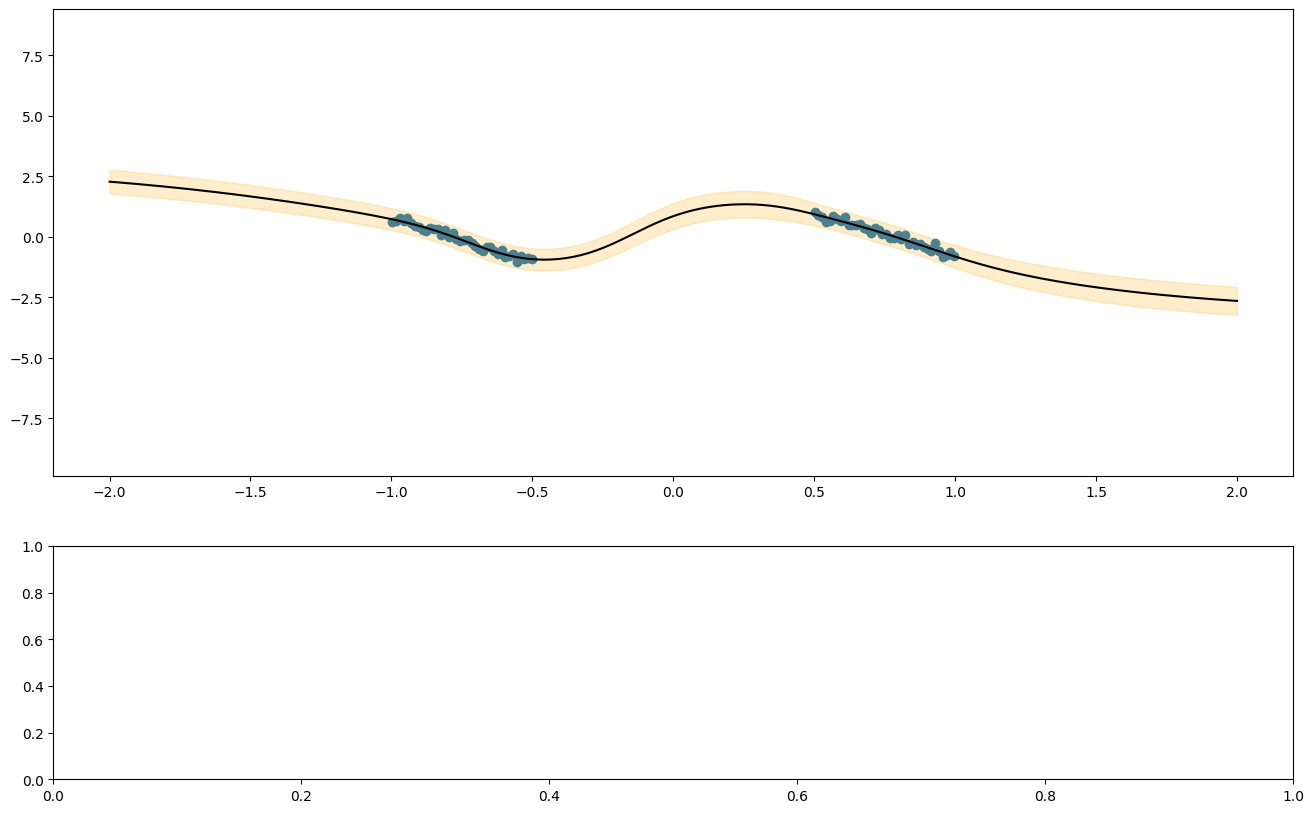

In [52]:

plt.rcParams["pdf.fonttype"] = 42
fig, axis = plt.subplots(2, 1, 
                         gridspec_kw={"height_ratios": [2, 1]}, 
                         figsize=(16, 10))


axis[0].scatter(train_dataset.inputs, 
                train_dataset.targets * train_dataset.targets_std + train_dataset.targets_mean, 
                label="Training points")




ella_mean, ella_var = forward(ella, test_loader)
ella_std = np.sqrt(ella_var).flatten() 


sort = np.argsort(test_dataset.inputs.flatten())


axis[0].plot(
    test_dataset.inputs.flatten()[sort],
    ella_mean.flatten()[sort],
    label="Predictions",
    color="black",
)
axis[0].fill_between(
    test_dataset.inputs.flatten()[sort],
    ella_mean.flatten()[sort] - 2 * ella_std[sort],
    ella_mean.flatten()[sort] + 2 * ella_std[sort],
    alpha=0.2,
    label="VaLLA uncertainty",
    color="orange",
)
axis[0].set_ylim(ylims)

# VaLLA

In [43]:
Z = kmeans2(train_dataset.inputs, params["num_inducing"], 
            minit="points", seed=params["seed"])[0]


Define DVIP model

In [44]:
valla = VaLLARegression(
    create_ad_hoc_mlp(f),
    Z,
    alpha=params["bb_alpha"],
    prior_std=prior_std,
    log_variance=log_variance,
    num_data=train_dataset.inputs.shape[0],
    output_dim=1,
    track_inducing_locations=True,
    y_mean=train_dataset.targets_mean,
    y_std=train_dataset.targets_std,
    device=params["device"],
    dtype=params["dtype"],
)

Initializing inducing classes with 1 different classes


In [45]:
valla.freeze_ll()
valla.freeze_prior()
valla.print_variables()


---- MODEL PARAMETERS ----
 inducing_locations: (5, 1)
                     [-0.87625418 -0.62207358 ...  0.76923077  0.92976589]
 L: (15)
    [1. 0. ... 0. 1.]

---------------------------




Start training.

In [46]:
opt = torch.optim.Adam(valla.parameters(), lr=params["lr"])

loss = fit(
    valla,
    train_loader,
    opt,
    use_tqdm=True,
    return_loss=True,
    iterations=params["iterations"],
    device=params["device"],
)

Training :   0%|          | 0/2000 [00:00<?, ? iteration/s]

Training : 100%|██████████| 2000/2000 [00:07<00:00, 261.22 iteration/s]


In [47]:
valla.print_variables()


---- MODEL PARAMETERS ----
 inducing_locations: (5, 1)
                     [-0.89151088 -0.65478865 ...  0.71819644  0.94039327]
 L: (15)
    [2.36923335 0.19467604 ... 1.06774206 2.19855495]

---------------------------




Compute test metrics.

(-9.880321196376562, 9.405573628308202)

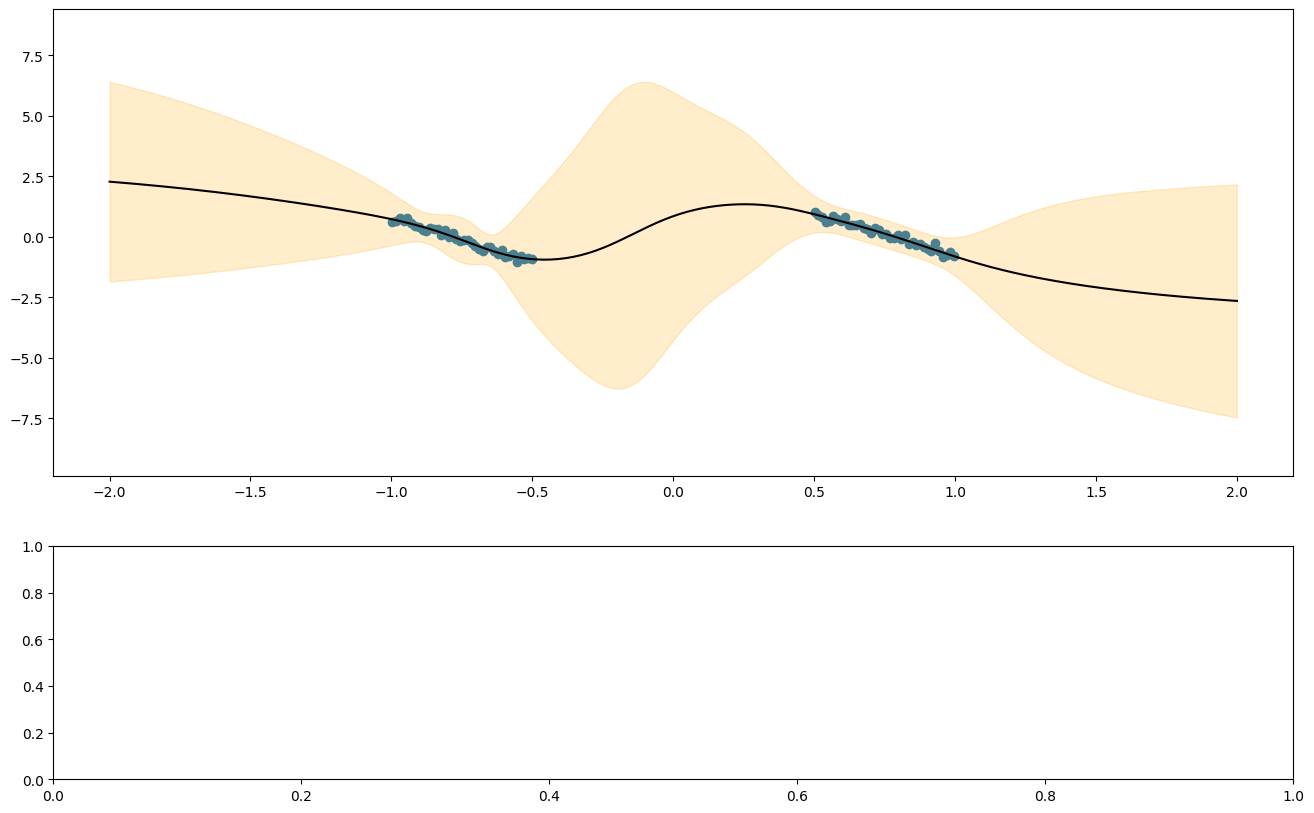

In [53]:

plt.rcParams["pdf.fonttype"] = 42
fig, axis = plt.subplots(2, 1, 
                         gridspec_kw={"height_ratios": [2, 1]}, 
                         figsize=(16, 10))


axis[0].scatter(train_dataset.inputs, 
                train_dataset.targets * train_dataset.targets_std + train_dataset.targets_mean, 
                label="Training points")



Z = valla.inducing_locations.detach().cpu().numpy()


valla_mean, valla_var = forward(valla, test_loader)
valla_std = np.sqrt(valla_var).flatten()


sort = np.argsort(test_dataset.inputs.flatten())


axis[0].plot(
    test_dataset.inputs.flatten()[sort],
    valla_mean.flatten()[sort],
    label="Predictions",
    color="black",
)
axis[0].fill_between(
    test_dataset.inputs.flatten()[sort],
    valla_mean.flatten()[sort] - 2 * valla_std[sort],
    valla_mean.flatten()[sort] + 2 * valla_std[sort],
    alpha=0.2,
    label="VaLLA uncertainty",
    color="orange",
)
axis[0].set_ylim(ylims)
